In [126]:
from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
#from xml.etree import ElementTree as ET
#from IPython.core.debugger import set_trace
import seaborn as sns
import random
from ta import add_all_ta_features
from ta.utils import dropna
from ta.trend import *

In [9]:
# Connect to IB Server
ib=IB()
util.startLoop()
ib.connect('127.0.0.1',7497, clientId= 6595)

<IB connected to 127.0.0.1:7497 clientId=6595>

$\textbf{Construct function and define contracts using ib-insync to get historical data from IB}$

In [12]:
#define a function to get IB data. endDate is the last date of the historical data 

def get_data(contract, history, freq, side, endDate =''):
    
    bar = ib.reqHistoricalData(
        contract,
        endDateTime = endDate,
        durationStr=history,
        barSizeSetting= freq,
        whatToShow=side,
        useRTH=True,
        formatDate=1)
    
# use util in ib-insync to convert bar data into pandas dataframe    
    df = util.df(bar)
# return df 
    return df 
# find a stock contract and fully qualify it with all the attributes

history = '3 Y'
freq = '1 day'
side ='Trades' # last trade, or ASK, or Bid

ticker1 ='GME'
ticker2 = 'TLT'
ticker3 = 'DIA'

contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract1)

contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

contract3 = Contract(symbol = ticker3, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract3)

endDate = '20210101 23:59:59' 

df1 = get_data(contract1, history, freq, side,endDate )
df2 = get_data(contract2, history, freq, side,endDate )

$\textbf {The following are code examples for Lecture 9 - Momentum and Trend Following Strategies}$

<AxesSubplot:>

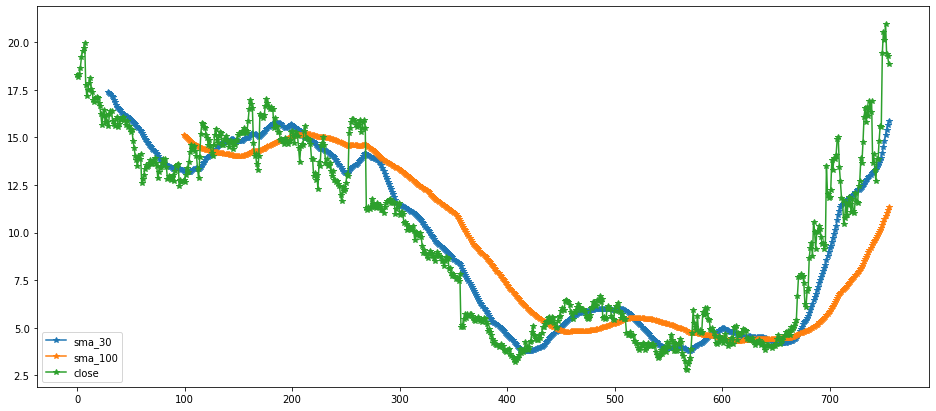

In [13]:
from ta.momentum import *
from ta.volatility import BollingerBands

rsi = rsi(df1.close, window =20)
sma = sma_indicator(df1.close, window =30)
smal = sma_indicator(df1.close, window =100)
ema= ema_indicator(df1.close, window =20)
bb_h = BollingerBands(df1.close, window=20, window_dev=2).bollinger_hband() 
bb_l = BollingerBands(df1.close, window=20, window_dev=2).bollinger_lband() 
bb_m = BollingerBands(df1.close, window=20, window_dev=2).bollinger_mavg() 

sma.plot(figsize =[16,7], legend = True, marker ="*")
smal.plot( legend = True,marker ="*")
#ema.plot(legend = True)
#rsi.plot(figsize =[10,10])
#bb_h.plot(legend = True)
#bb_l.plot(legend = True)
#bb_m.plot(legend = True)
df1.close.plot(legend = True,marker ="*")

In [123]:
# Form log price series

df1['log'] = get_data(contract1, history, freq, side )['close'].apply(lambda x: math.log(x))
df2['log'] = get_data(contract2, history, freq, side )['close'].apply(lambda x: math.log(x))


<AxesSubplot:>

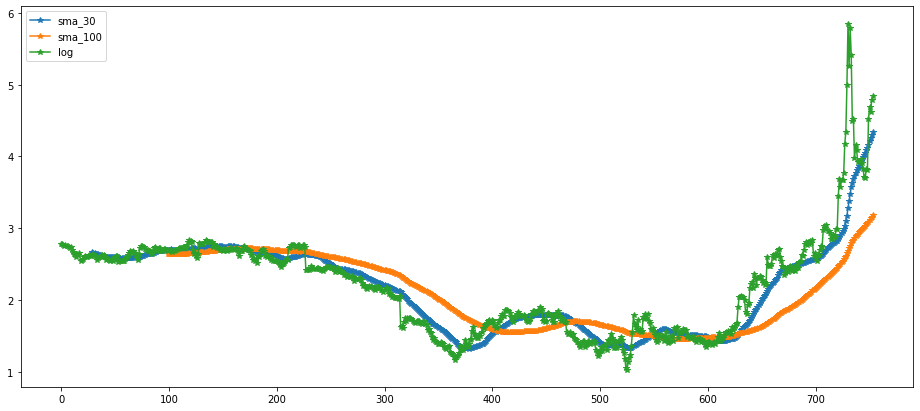

In [15]:
from ta.momentum import *
from ta.volatility import BollingerBands

rsi = rsi(df1.log, window =20)
sma = sma_indicator(df1.log, window =30)
smal = sma_indicator(df1.log, window =100)
ema= ema_indicator(df1.log, window =20)
bb_h = BollingerBands(df1.log, window=20, window_dev=2).bollinger_hband() 
bb_l = BollingerBands(df1.log, window=20, window_dev=2).bollinger_lband() 
bb_m = BollingerBands(df1.log, window=20, window_dev=2).bollinger_mavg() 

sma.plot(figsize =[16,7], legend = True,marker ="*")
smal.plot(figsize =[16,7], legend = True,marker ="*")
#ema.plot(legend = True)
#rsi.plot(figsize =[10,10])
#bb_h.plot(legend = True)
#bb_l.plot(legend = True)
#bb_m.plot(legend = True)
df1.log.plot(legend = True,marker ="*")


$\textbf {The following codes are examples used in Lecture 10}

In [19]:
# Some Examples for Pairs Trading
# Find stock prices history using ib-insync

history = '3 Y'
freq = '1 day'
side ='Trades' # last trade, or ASK, or Bid

ticker1 ='TXN'
ticker2 = 'ADI'

contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract1)

contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

#endDate = '20210101 23:59:59' 
endDate =''

df1 = get_data(contract1, history, freq, side,endDate )
df2 = get_data(contract2, history, freq, side,endDate )

df1[ticker1+'_log'] = get_data(contract1, history, freq, side )['close'].apply(lambda x: math.log(x))
df2[ticker2+'_log'] = get_data(contract2, history, freq, side )['close'].apply(lambda x: math.log(x))

df1['log_diff'] = df1[ticker1+'_log']-df2[ticker2+'_log']

<AxesSubplot:label='626df91b-8b22-40b0-96c9-660da556daee'>

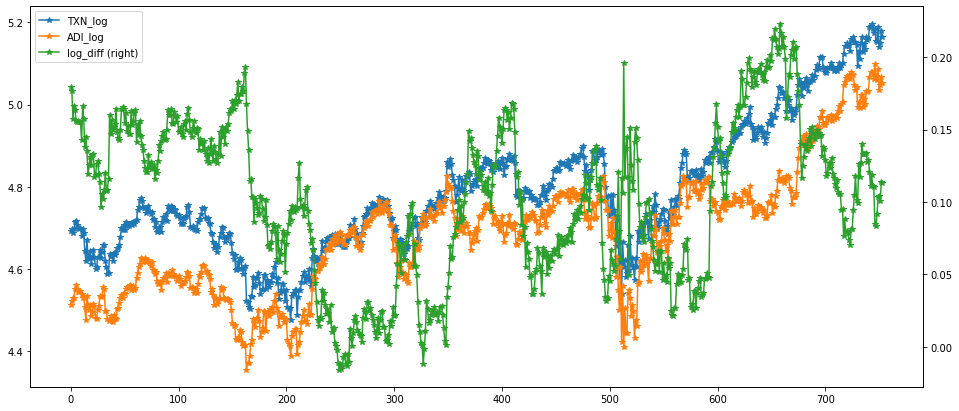

In [20]:
df1[ticker1+'_log'].plot(figsize = [16,7], marker ="*", legend =True)
df2[ticker2+'_log'].plot(figsize = [16,7],marker ="*", legend =True)
df1['log_diff'].plot(figsize = [16,7], secondary_y = ['log_diff'],marker ="*", legend =True)

<AxesSubplot:title={'center':'Normalized Log Difference'}>

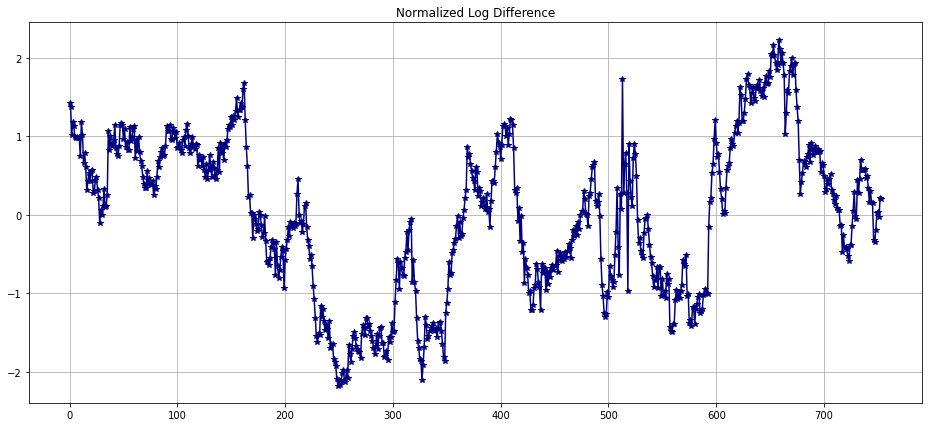

In [21]:
df1['norm_log_diff'] = (df1['log_diff'] - df1.log_diff.mean())/df1.log_diff.std()

df1['norm_log_diff'].plot(figsize = [16,7], secondary_y = ['log_diff'],marker ="*", title ='Normalized Log Difference', grid=True, color ='navy')


<AxesSubplot:>

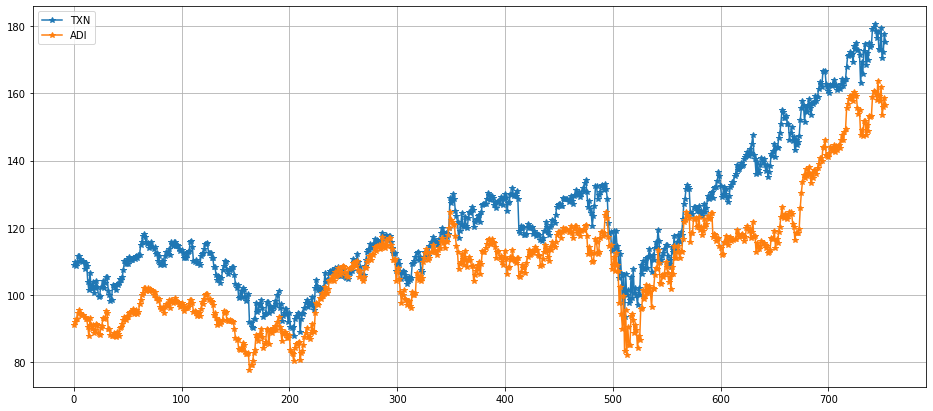

In [22]:
df1[ticker1] = df1['close']
df2[ticker2] = df2['close']

df1[ticker1].plot(figsize = [16,7], marker ="*", legend =True, grid=True)
df2[ticker2].plot(figsize = [16,7],marker ="*", legend =True, grid=True)

Text(4.5, 4.97, ' Hedge Ratio = Slope of the Linear Regression Equation: Y = 0.91 X + 0.32')

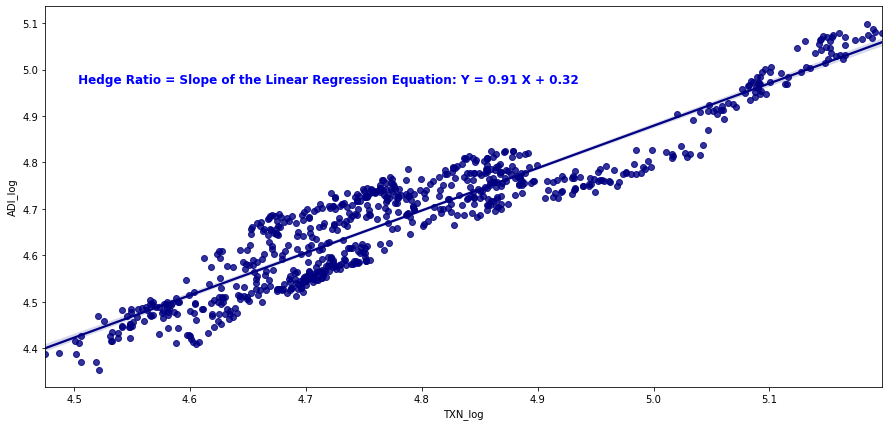

In [23]:
#Fine the hedge ratio with linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df1[ticker1+'_log'],df2[ticker2+'_log'])

plt.figure(figsize=(15, 7))

p= sns.regplot(x=df1[ticker1+'_log'], y=df2[ticker2+'_log'],color = 'navy',
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

p.text(4.5, 4.97, " Hedge Ratio = Slope of the Linear Regression Equation: Y = " + str('{:.2f}'.format(slope))+" X + " +str('{:.2f}'.format(intercept)) , horizontalalignment='left', size='large', color='blue', weight='semibold')


$\textbf{Lecuture 11 Code Examples  }$

$\textbf{11.1 - Testing Momentum Tendency of Different Stocks with AutoCorrelation}$

In [292]:
'''
Set up contracts and get historical price. We will simple statistics to identify the potential momentous stocks 
that could work the best for moementumn strategy, either trend following or trend reversal strategy. It is simply based 
on the autocorrelations among the return series, or, the difference in log prices.

'''

history = '2 Y'
freq = '1 day'
side ='Trades' # last trade, or ASK, or Bid
endDate ='' # enddate is today
#endDate = '20210101 23:59:59' 

ticker1 ='CRWD'
ticker2 = 'JPM'

contract1 = Contract(symbol = ticker1, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract1)

contract2 = Contract(symbol = ticker2, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract2)

df1 = get_data(contract1, history, freq, side,endDate )
df2 = get_data(contract2, history, freq, side,endDate )

df1[ticker1+'_log'] = get_data(contract1, history, freq, side )['close'].apply(lambda x: math.log(x))
df2[ticker2+'_log'] = get_data(contract2, history, freq, side )['close'].apply(lambda x: math.log(x))

#df1['log_diff'] = df1[ticker1+'_log']-df2[ticker2+'_log']
df1[ticker1+'_log_diff']= df1[ticker1+'_log'].diff()
df2[ticker2+'_log_diff']= df2[ticker2+'_log'].diff()

$\textbf{Recall that it is important to work with log prices, and the difference in log prices approximate the stock returns}$

$ \mathbf {log(P_t) - log(P_{t-1}) = log (\frac{P_t}{P_{t-1}}) \approx \frac{P_t}{P_{t-1}} - 1 = \frac{P_t-P_{t-1}}{P_{t-1}} }$

In [293]:
#Compute the autocorrelation for the the full time period history

[df1[ticker1+'_log_diff'].autocorr(lag =1), df2[ticker2+'_log_diff'].autocorr(lag =1)]

[0.042937782588959875, -0.2276471002127573]

<AxesSubplot:title={'center':'90-day Rolling Autocorrelation'}, xlabel='date'>

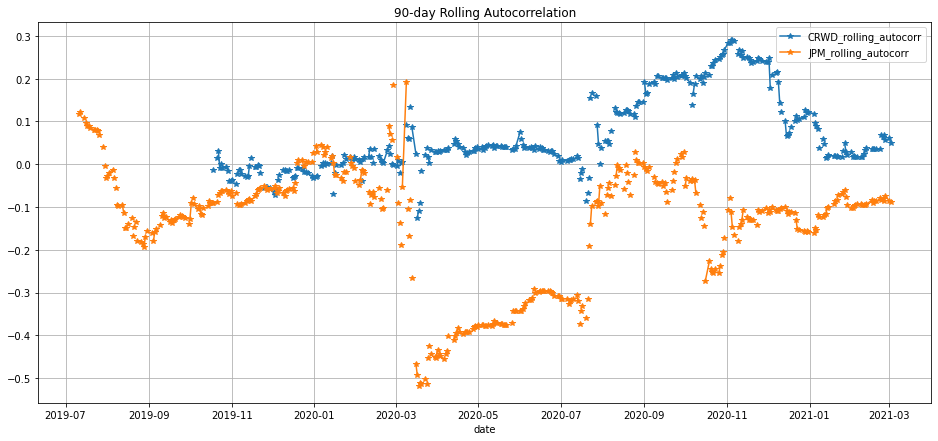

In [295]:
#Let us take a look at the rolling autocorrelation to see the trend in hsitory

rolling = 90 # rolling period 
df1[ticker1+'_rolling_autocorr']= df1[ticker1+'_log_diff'].rolling(rolling).apply(lambda x: pd.Series(x).autocorr(1))
df2[ticker2+'_rolling_autocorr']= df2[ticker2+'_log_diff'].rolling(rolling).apply(lambda x: pd.Series(x).autocorr(1))                                 

# Graph the time series of autocorrelation
df = pd.concat([df1,df2])
df.plot(title = str(rolling) + '-day Rolling Autocorrelation', figsize = [16,7], x = 'date', y =[  ticker1+'_rolling_autocorr',ticker2+'_rolling_autocorr'],  marker ="*", legend =True, grid=True)

#df2.plot(figsize = [16,7], x = 'date', y = ticker2+'_rolling_autocorr', marker ="*", legend =True, grid=True)
#df2[ticker2+'_rolling_autocorr'].plot(figsize = [16,7],marker ="*", legend =True, grid=True)

$\textbf {The above chart indicates that high flying internet stock has more moemtum than a bamk stock like JPM. It is important to understand the kind of stocks before you apply a particular strategy. Certain strategy may nor work becasue it is applied to wrong kind of stocks. Questions to consider:}$



1. What kind of statistics that you should perform to determine if a stock approprite for a menmentum strategy?

2. What are the time hsitorical time period to use?

3. What are the statsitical significance level?

4. When shoulf you stop the strategy as market regimes change?

5.  How do you spot the market regime change?



$\textbf{Dickey-Fuller Test (or Unit Root Test) and Pairs Trading}$

$\textbf{The hypothesis that undelrying the pairs-trading strategy is that the residual time series is mean-reverting.}$ 

$\textbf{We need to test this hypothesis with enough confidence to enter into positions. Otherwise, we would have nasty surprices in live trading }$

$\textbf{How can we test if the residual is mean-reverting. The answer is Dickey-Fuller Test }$

$ \textbf {The notations and math equations are:}$

$\mathbf {Y = \beta X + \alpha+\epsilon , \: where \: \beta \: is : the \: slope,\: \alpha \: is\: the \: intercept,\: \epsilon \: is \: the \: residual. \: \sigma = standard \: deviation \: of \: \epsilon, \: zscore =\mathbf{\frac{\epsilon}{\sigma}}} $

In [304]:
# We will use the OLS moduel in the Statsmodels package

Y = df1[ticker1+'_log']
X = df2[ticker2+'_log']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
sigma = math.sqrt(results.mse_resid) # standard deviation of the residual
slope = results.params[1]
intercept = results.params[0]
res = results.resid #regression residual mean of res =0 by definition
zscore = res/sigma
adf = adfuller (res)  # ADF Test -- Augmented Dickey-Fuller test for unit root

#for a new pandas dataframe using concat method to contain only relevant information
dg = pd.concat([res, zscore], axis =1)
dg = pd.concat([Y,dg], axis =1)
dg = pd.concat([X,dg], axis =1)
dg.columns =[ 'const', ticker1+'_log', ticker2+'_log', 'residual', 'zscore']
dg['date']= df2.date



$\textbf{Additonal Statistical Tests on Residual for "Stability"}$

Additional tests performed to ensure the residual is relatively stable in the sense that its variance is relatively constant as underlying stock price changes. Otherwsie, this could create large risks for paris trading strategy as discussed in the class. We test for $\textbf {heteroskedasticity}$, a condition that the variance of the residual is staistically correlated to the independent varaible. We use two standard tests: $\textbf{Breusch-Pagan Test and White Test}$. We also test for the normality of the residual, while it is nice for residual to be normally distributed, but the more important property is to have a stable or bounded residual value that is mean reverting.

In [311]:
#some additional test on residual to ensure it sort of "staionary" 
jb= statsmodels.stats.stattools.jarque_bera(res)[1] # p_value of Jarque_bera Test for normality of residual
bp=statsmodels.stats.diagnostic.het_breuschpagan(res, X)[3] # p_value of BrueschPaga Test for heteroskedasticity
wt = statsmodels.stats.diagnostic.het_white(res, X)[3] # p_value of White Test for heteroskedasticity

[jb,bp,wt]

[2.4364706580946428e-57, 1.039937288386619e-06, 3.894142330322217e-06]

<AxesSubplot:title={'center':'SPY-QQQ Pairs-Trading Backtesting with ADF = 0%\n Lookback = 1 Y and endDate= 20200101 23:59:59'}, xlabel='date'>

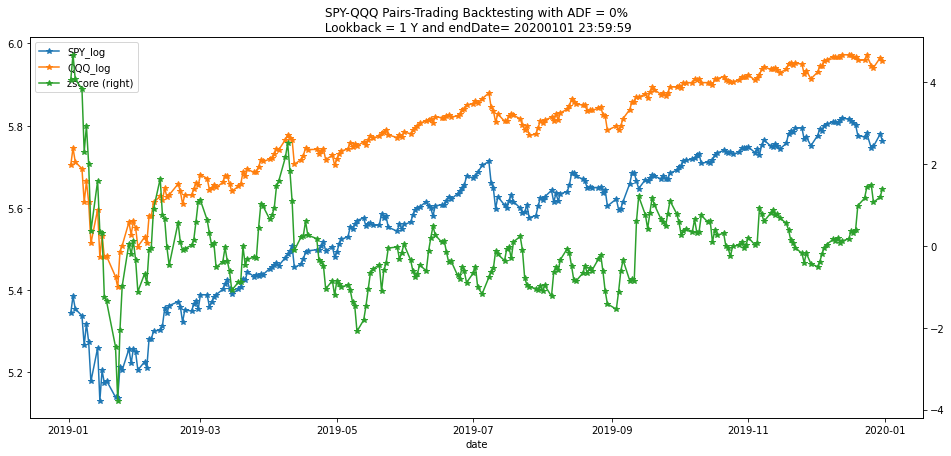

In [298]:
# Graph the log prices and zscores
dg.plot (title = str(ticker1) + '-' +str(ticker2) +  ' Pairs-Trading Backtesting with ADF = '+"{:.00%}".format(adf[1]) +'\n Lookback = ' + str(history) + ' and endDate= ' + str(endDate), figsize =[16,7], x ='date', y=[ticker1+'_log',ticker2+'_log', 'zscore'], secondary_y ='zscore', marker = "*")

$\textbf{Python staitiscal analysis is an important part of the clas. Here are some additional code examples for you to study.}$

https://github.com/fonnesbeck/statistical-analysis-python-tutorial